# Import Packages

In [23]:
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('vader_lexicon')
import string
import contractions
import re
import gensim
import pprint
from itertools import chain
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, words
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from dotenv import load_dotenv
from collections import Counter
from gensim import corpora
from gensim.models import CoherenceModel
from itertools import product

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marcus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Import Data from Database

In [22]:


load_dotenv()
postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')


def create_df():
    try:
        conn = psycopg2.connect(
            host=host,
            user=user,
            password=postgres_password,
            port=postgres_port_no,
            database=database)
        query = "SELECT * FROM RATINGS AS R LEFT JOIN PRODUCTS AS P ON  R.PRODUCT_ID = P.PRODUCT_ID "
        # Read data from the database into a DataFrame
        df = pd.read_sql(query, con=conn)
        return df
    except Exception as e:
        print("An error occurred:", e)
        conn.rollback()  # Rollback in case of error
    finally:
        conn.close()  # Close the connection
# Display the DataFrame
product_ratings_df = create_df()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marcus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/73/fb491fb94kj3nr6_byql8qdh0000gn/T/ipykernel_20575/1308209861.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)


## Read in Data

In [12]:
product_ratings_df.rename(columns={
    'review_title': 'short_reviews',
    'review_content': 'long_reviews'
}, inplace=True)

# EDA

Product category e.g: "Computers&Accessories|NetworkingDevices|NetworkAdapters|WirelessUSBAdapters"

- We split the categoties to main and sub main category.

- By identifying the base category, we can understand the broader classification of the product, while the sub category tells us more specifically what the product is.

In [13]:
#split product categories into its base_category and sub_category
product_ratings_df["category"]
product_ratings_df["base_category"] = product_ratings_df["category"].str.split("|").str[0]
product_ratings_df["sub_category"] = product_ratings_df["category"].str.split("|").str[-1]

### Number of reviews in each category

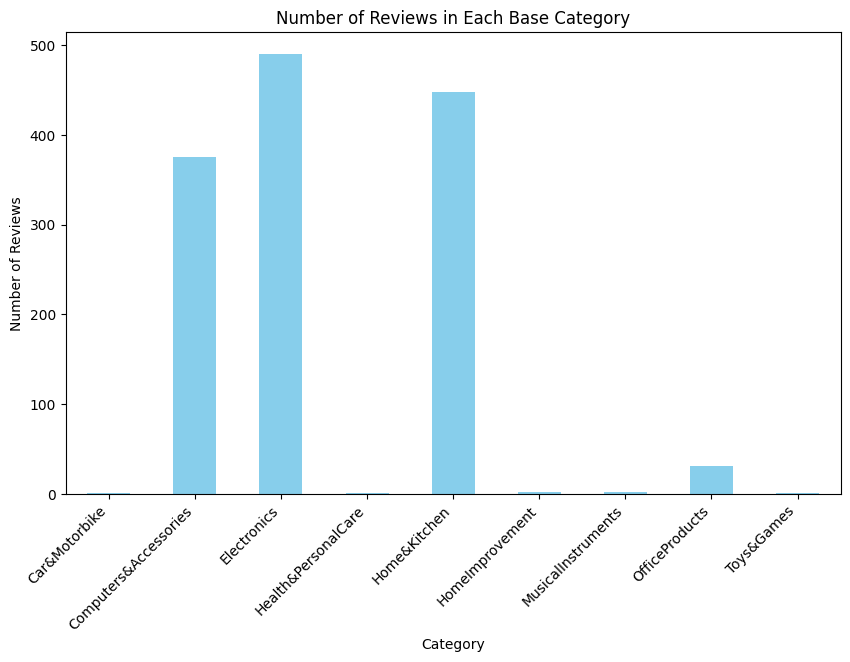

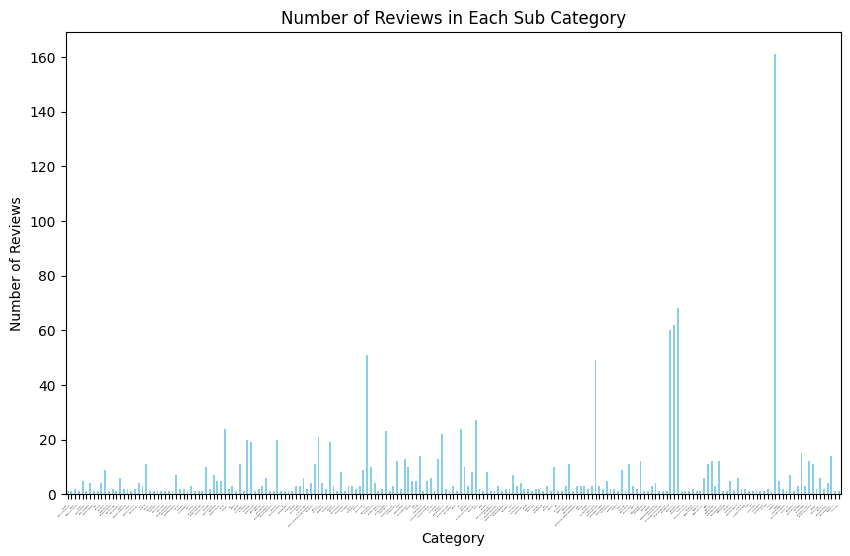

Sub category with the most number of reviews: sub_category
USBCables      161
Smartphones     68
Name: average_rating, dtype: int64


In [14]:
# Group by category and count the number of reviews in each
base_category_counts = product_ratings_df.groupby('base_category')['average_rating'].count()
sub_category_counts = product_ratings_df.groupby('sub_category')['average_rating'].count()

# Plot the result
plt.figure(figsize=(10,6))
base_category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Reviews in Each Base Category')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right') 
plt.show()


# Plot the result
plt.figure(figsize=(10,6))
sub_category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Reviews in Each Sub Category')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right', fontsize=1) 
plt.show()
max_sub_category = sub_category_counts.nlargest(2)
print(f"Sub category with the most number of reviews: {max_sub_category}")

### Distribution of reviews

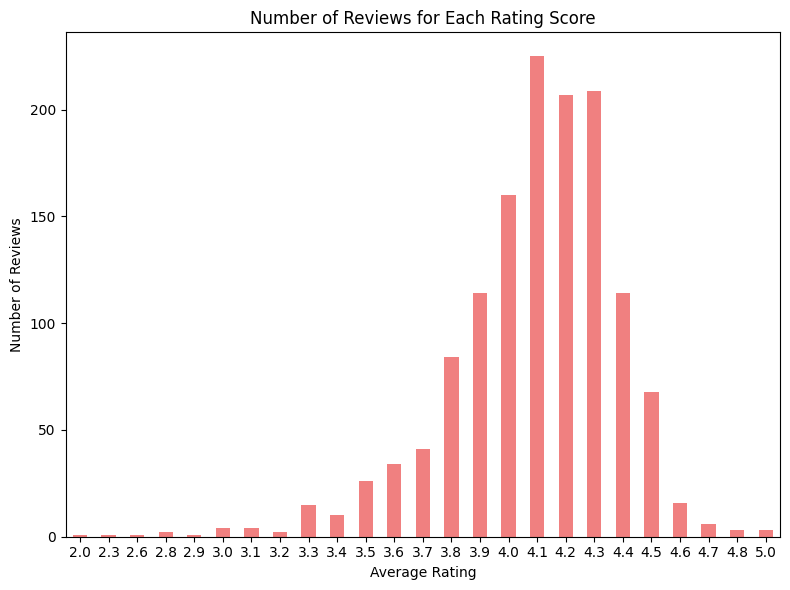

In [15]:
# Group by average rating and count the number of reviews for each rating
rating_counts = product_ratings_df.groupby('average_rating').size()

# Plot the result
plt.figure(figsize=(8,6))
rating_counts.plot(kind='bar', color='lightcoral')
plt.title('Number of Reviews for Each Rating Score')
plt.xlabel('Average Rating')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for readability
plt.tight_layout()
plt.show()


Since most average ratings are relatively high, around 4 out of 5, we can define a 'poor rating' as any rating below the 30th percentile of the rating distribution. This will help identify the lower portion of ratings relative to the overall spread.

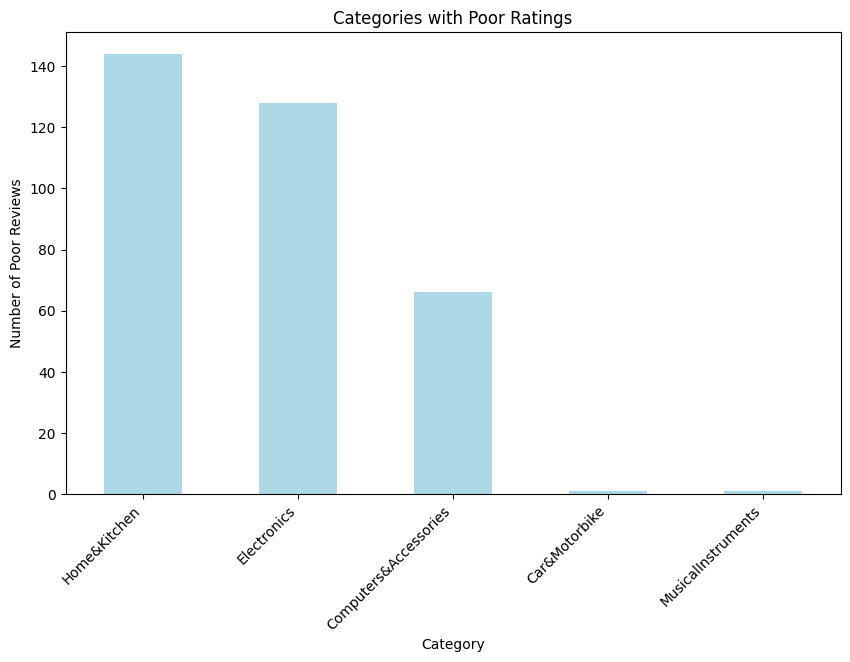

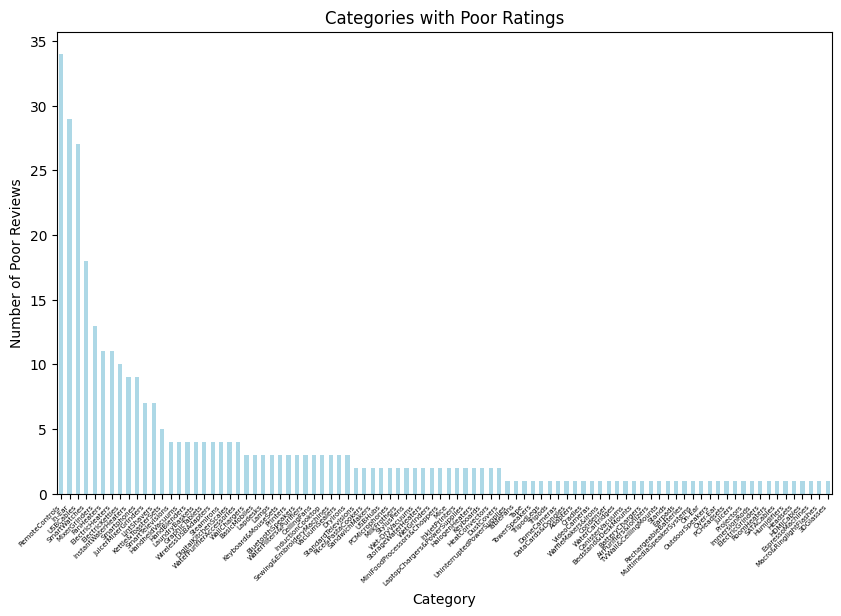

Sub category with the most number of poor reveiws: sub_category
RemoteControls         34
In-Ear                 29
USBCables              27
SmartWatches           18
MixerGrinders          13
FanHeaters             11
ElectricHeaters        11
ElectricKettles        10
InstantWaterHeaters     9
Smartphones             9
dtype: int64


In [16]:
percentile_30 = np.percentile(product_ratings_df['average_rating'], 30)

poorly_rated_df = product_ratings_df[product_ratings_df['average_rating'] < percentile_30]

# Group by category and count the number of poorly rated reviews for each category
base_poorly_rated_counts = poorly_rated_df.groupby('base_category').size()
sub_poorly_rated_counts = poorly_rated_df.groupby('sub_category').size()

# Sort the counts to make the plot more readable
base_poorly_rated_counts = base_poorly_rated_counts.sort_values(ascending=False)
sub_poorly_rated_counts = sub_poorly_rated_counts.sort_values(ascending=False)

# Plot the result
plt.figure(figsize=(10,6))
base_poorly_rated_counts.plot(kind='bar', color='lightblue')
plt.title('Categories with Poor Ratings')
plt.xlabel('Category')
plt.ylabel('Number of Poor Reviews')
plt.xticks(rotation=45, ha='right') 
plt.show()

plt.figure(figsize=(10,6))
sub_poorly_rated_counts.plot(kind='bar', color='lightblue')
plt.title('Categories with Poor Ratings')
plt.xlabel('Category')
plt.ylabel('Number of Poor Reviews')
plt.xticks(rotation=45, ha='right', fontsize = 5) 
plt.show()
max_sub_category = sub_poorly_rated_counts.nlargest(10)
print(f"Sub category with the most number of poor reveiws: {max_sub_category}")

We can see that most poorly rated products are from categories "Electronic" and "Home&Kitchen"

# Sentiment Analysis

### Vader Analysis

In [17]:
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marcus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### `short_reviews` and `long_reviews` columns are a `str` of mutliple reviews

e.g "Works Good, Perfect replacement cell for trimmer,Wow,As they said in ad worth it,A good product,Fit for phillips trimmer.,Good,Good Product"

In [18]:
def get_vader_score(text:str):
    indiv_reviews = text.split(",") #split str into list of individual strs
    vader_scores = [analyzer.polarity_scores(text).get("compound") for text in indiv_reviews] # apply vader analysis to each reviews
    avg_vader_scores = sum(vader_scores)/len(vader_scores) # get avg vader scores over all reviews
    return avg_vader_scores


product_ratings_df['long_reviews_vader_analysis'] = product_ratings_df['long_reviews'].apply(get_vader_score)
product_ratings_df['short_reviews_vader_analysis'] = product_ratings_df['short_reviews'].apply(get_vader_score)


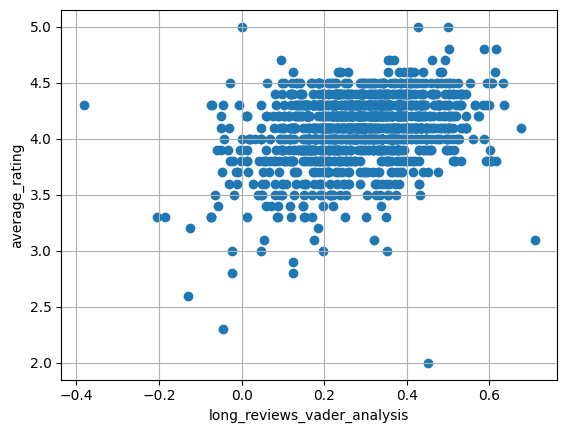

In [19]:
plt.scatter(product_ratings_df['long_reviews_vader_analysis'], product_ratings_df['average_rating'])
plt.xlabel('long_reviews_vader_analysis')
plt.ylabel('average_rating')
plt.grid(True)
plt.show()

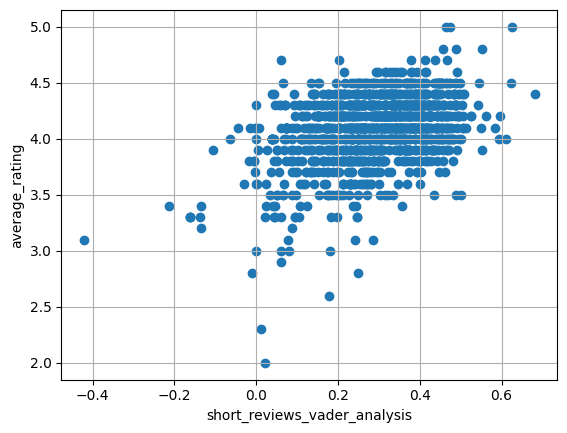

In [20]:
plt.scatter(product_ratings_df['short_reviews_vader_analysis'], product_ratings_df['average_rating'])
plt.xlabel('short_reviews_vader_analysis')
plt.ylabel('average_rating')
plt.grid(True)
plt.show()

### Outliers

In [32]:
filtered_df = product_ratings_df[(product_ratings_df['long_reviews_vader_analysis'] < -0.2) & (product_ratings_df['average_rating'] > 4)]
pd.set_option('display.max_colwidth', None)
filtered_df["long_reviews"]

1107    tv on off not working, so difficult to battery really a bad product
Name: long_reviews, dtype: object

# Identifying Common Issues

### Text Cleaning and Preprocessing

In [44]:
stop = set(stopwords.words('english'))

stop.remove("not") #exclude "not" from stopwords as goal of TF-IDF is to identify words that are informative for distinguishing between different documents or classes
english_words = set(words.words())
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    #remove contractions
    cont_free = contractions.fix(doc)

    #remove hyperlinks
    URL_PATTERN = r'https?://\S+|www\.\S+'
    # Substitute URLs with an empty string
    url_free = re.sub(URL_PATTERN, '', cont_free)

    #remove stop words
    stop_free = " ".join([i for i in url_free.lower().split() if i not in stop])
    non_eng_free = " ".join([i for i in stop_free.lower().split() if i in english_words])

    punc_free = ''.join(ch for ch in non_eng_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())

    return normalized


product_ratings_df["clean_short_reviews"] = product_ratings_df["short_reviews"].apply(clean)
product_ratings_df["clean_long_reviews"] = product_ratings_df["long_reviews"].apply(clean)

We identify and collate negative reviews using the VADER sentiment analysis tool. 

Define a negative review with a compound VADER score below **-0.25**

    DOCS_BAD_LONG_REVIEWS (list): A list of tokenized words from negative long reviews.
    BAD_LONG_REVIEWS (list): A list of cleaned negative long reviews.
    DOCS_BAD_SHORT_REVIEWS (list): A list of tokenized words from negative short reviews.
    BAD_SHORT_REVIEWS (list): A list of cleaned negative short reviews.

In [46]:
## Collate all individual bad long reviews with vader analysis < -0.25
DOCS_BAD_LONG_REVIEWS = []
BAD_LONG_REVIEWS = []

all_long_reviews = list(product_ratings_df["long_reviews"])

for reviews in all_long_reviews:
    indiv_reviews = reviews.split(",") #split str into list of individual strs
    for review in indiv_reviews:
        vader_score = analyzer.polarity_scores(review).get("compound") # apply vader analysis to each reviews
        if vader_score < -0.25:
            # print(review , vader_score)
            BAD_LONG_REVIEWS.append(clean(review))
            DOCS_BAD_LONG_REVIEWS.append(clean(review).split())



## Collate all individual bad short reviews with vader analysis < -0.25
DOCS_BAD_SHORT_REVIEWS = []
BAD_SHORT_REVIEWS = []

all_short_reviews = list(product_ratings_df["short_reviews"])

for reviews in all_short_reviews:
    indiv_reviews = reviews.split(",") #split str into list of individual strs
    for review in indiv_reviews:
        vader_score = analyzer.polarity_scores(review).get("compound") # apply vader analysis to each reviews
        if vader_score < -0.3:
            BAD_SHORT_REVIEWS.append(clean(review))
            DOCS_BAD_SHORT_REVIEWS.append(clean(review).split())


## Analyse most frequent phrases in negative reviews

By examining the top n-grams in bad reviews, we can pinpoint specific features or issues that contribute to negative sentiment 

In [21]:
def create_ngrams(token_list, nb_elements):
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (" ".join(ngram) for ngram in ngrams)

def frequent_words(list_words, ngrams_number=2, number_top_words=10):
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent


### N-grams for bad short reviews

In [61]:
unlist_docs_short_reviews = list(chain.from_iterable(DOCS_BAD_SHORT_REVIEWS))
print(" ## FREQUENT WORDS FROM BAD SHORT REVIEWS")
print("2-gram")
pprint.pprint(frequent_words(unlist_docs_short_reviews, ngrams_number=2))
print("\n")
print("3-gram")
pprint.pprint(frequent_words(unlist_docs_short_reviews, ngrams_number=3))


 ## FREQUENT WORDS FROM BAD SHORT REVIEWS
2-gram
[('not good', 70),
 ('good not', 31),
 ('product not', 17),
 ('quality not', 14),
 ('poor quality', 13),
 ('not best', 11),
 ('not support', 11),
 ('dull physical', 10),
 ('not excellent', 9),
 ('waste money', 9)]


3-gram
[('not good not', 15),
 ('good not excellent', 9),
 ('quality not good', 9),
 ('not excellent budget', 8),
 ('product not good', 6),
 ('dull physical dull', 6),
 ('physical dull physical', 6),
 ('good not best', 5),
 ('good price o', 5),
 ('good not good', 4)]


### N-grams for bad long reviews

In [62]:
unlist_docs_long_reviews = list(chain.from_iterable(DOCS_BAD_LONG_REVIEWS))
print(" ## FREQUENT WORDS FROM BAD LONG REVIEWS")
print("2-gram")
pprint.pprint(frequent_words(unlist_docs_long_reviews, ngrams_number=2))
print("\n\n")
print("3-gram")
pprint.pprint(frequent_words(unlist_docs_long_reviews, ngrams_number=3))

 ## FREQUENT WORDS FROM BAD LONG REVIEWS
2-gram
[('not good', 121),
 ('quality not', 38),
 ('product not', 29),
 ('not support', 27),
 ('also not', 26),
 ('sound quality', 25),
 ('battery life', 22),
 ('not great', 21),
 ('not working', 21),
 ('not like', 21)]



3-gram
[('quality not good', 18),
 ('battery life not', 10),
 ('even mentally prepared', 8),
 ('mentally prepared bad', 8),
 ('prepared bad camera', 8),
 ('bad camera little', 8),
 ('camera little could', 8),
 ('little could heating', 8),
 ('could heating got', 8),
 ('heating got even', 8)]


**TF-IDF (Term Frequency-Inverse Document Frequency)** score for each term in the dataset, which is a measure of how important a word or phrase is in a given document relative to the entire corpus.

In [57]:
# Example to extract bigrams
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(BAD_LONG_REVIEWS)  # 'reviews' is your list of review texts
ngrams = vectorizer.get_feature_names_out()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 3), stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(BAD_LONG_REVIEWS)
tfidf_scores = tfidf_matrix.toarray()
terms = tfidf_vectorizer.get_feature_names_out()

# Mean TF-IDF score for each term
mean_scores = np.mean(tfidf_scores, axis=0)
top_ngrams = sorted(zip(mean_scores, terms), reverse=True)  # Highest scores first

# Display top 10 highest and lowest TF-IDF n-grams
top_10_highest = top_ngrams[:10]
top_10_lowest = top_ngrams[-10:]

print("Top 10 Highest TF-IDF N-grams:")
for score, term in top_10_highest:
    print(f"{term}: {score}")

Top 10 Highest TF-IDF N-grams:
quality good: 0.005186380123505044
battery life: 0.003559943843060822
good product: 0.0032367803450590493
sound quality: 0.002800393400115243
face problem: 0.002545105741328007
poor quality: 0.0025119178210962537
defective product: 0.002341645186948248
fast charging: 0.0022923279428061563
picture quality: 0.0021923633869340834
battery backup: 0.0020523368703480567


Examine reviews with frequent keywords

e.g. "poor quality"

In [63]:
def display_reviews_with_keyword(reviews, keyword):
    """Display reviews containing a specific keyword."""
    print(f"Reviews containing the keyword '{keyword}':\n")
    matched_reviews = [review for review in reviews if keyword in review.lower()]
    
    if not matched_reviews:
        print(f"No reviews found containing the keyword '{keyword}'.")
    else:
        for i, review in enumerate(matched_reviews, 1):
            print(f"{i}. {review}")

# Example usage:
keyword = 'poor quality'  # Replace with any n-gram of interest
display_reviews_with_keyword(BAD_LONG_REVIEWS, keyword)


Reviews containing the keyword 'poor quality':

1. poor quality
2. handle product broke used second time poor quality would not
3. not according international class item poor quality poorly quality control system
4. one broken received could see inside not metal instead like outside alone thin covering poor quality
5. work properly good product poor quality
6. work properly good product poor quality
7. poor quality month used printer print print also color print not working not
8. product work quality not smooth made poor quality shine dull still buy
9. poor quality stand
10. small body also poor quality
11. poor quality within month button not working
12. saying good bye delivery poor quality product current run away providing poor product poor resolution go buy
13. poor quality
14. extremely poor quality useless advise everyone not buy


## Topic Modelling : Latent Dirichlet allocation (LDA)

We will apply Topic Modeling technique such as Latent Dirichlet Allocation to **identify the common issues** in the reviews.

The **Latent Dirichlet Allocation (LDA)** model:
- unsupervised classification of documents
- probabilistic topic modeling algorithm used to discover the hidden topics in a collection of documents
- each document is modeled as a mixture of multiple topics, where each topic is a distribution over words
- the model assumes that documents have a latent (hidden) structure, where each topic is represented by a group of words, and documents are composed of these topics to varying degrees.


Limitations
1) Regarding content: It doesn't account for the order of words within a document. This means it may fail to capture the context, interpret sarcasm, or identify multi-word expressions that convey specific meaning

2) Determining the number of topics can be tricky: The optimal number of topics isn't known
beforehand and finding the right one can require several trial-and-error iterations

In [81]:

# Exclude words not helpful
stoplist = ['not', 'good']

# Preprocess DOCS_BAD_SHORT_REVIEWS to remove the unwanted words
DOCS_BAD_SHORT_REVIEWS_CLEANED = [
    [word for word in doc if word not in stoplist] 
    for doc in DOCS_BAD_SHORT_REVIEWS
]

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(DOCS_BAD_SHORT_REVIEWS_CLEANED)

# Filter extremes. Filter out extremely rare words (e.g., appearing in fewer than 2 documents) and very common words (e.g., appearing in more than 50% of the documents).
dictionary.filter_extremes(no_below=2, no_above=0.5)


# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in DOCS_BAD_SHORT_REVIEWS_CLEANED]


Grid search over different **numbers of topics** and **training passes** to identifying the most suitable number of topics by observing the coherence value.

Calculate topic coherence for topic models.

This is the implementation of the four stage topic coherence pipeline
- Segmentation
- Probability Estimation
- Confirmation Measure
- Aggregation


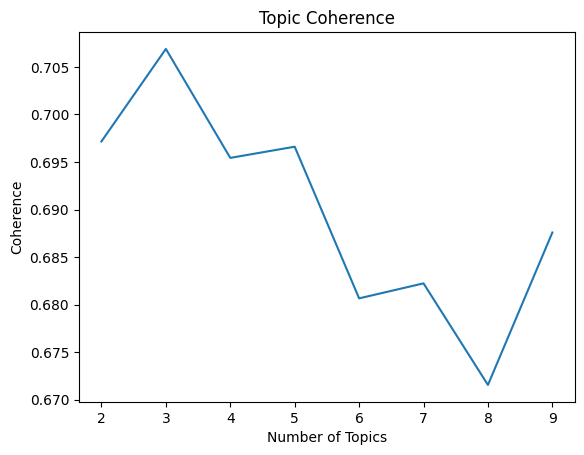

Num Topics = 2, Passes = 10, Coherence Value = 0.6972
Num Topics = 2, Passes = 20, Coherence Value = 0.7069
Num Topics = 3, Passes = 10, Coherence Value = 0.6954
Num Topics = 3, Passes = 20, Coherence Value = 0.6966
Num Topics = 4, Passes = 10, Coherence Value = 0.6807
Num Topics = 4, Passes = 20, Coherence Value = 0.6822
Num Topics = 5, Passes = 10, Coherence Value = 0.6716
Num Topics = 5, Passes = 20, Coherence Value = 0.6876
Num Topics = 6, Passes = 10, Coherence Value = 0.6578
Num Topics = 6, Passes = 20, Coherence Value = 0.6736
Num Topics = 7, Passes = 10, Coherence Value = 0.6602
Num Topics = 7, Passes = 20, Coherence Value = 0.6628
Num Topics = 8, Passes = 10, Coherence Value = 0.6606
Num Topics = 8, Passes = 20, Coherence Value = 0.6606
Num Topics = 9, Passes = 10, Coherence Value = 0.6475
Num Topics = 9, Passes = 20, Coherence Value = 0.6467


In [80]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step, passes_list):
    coherence_values = []
    model_list = []
    grid_search_results = []
    
    # Create combinations of num_topics, passes, and iterations
    for num_topics, passes in product(range(start, limit, step), passes_list):
        model = gensim.models.LdaModel(
            corpus=corpus, num_topics=num_topics, id2word=dictionary, 
            passes=passes,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        
        # Store each result in a tuple: (num_topics, passes, iterations, coherence_score)
        grid_search_results.append((num_topics, passes, coherence_score))
        
    return model_list, coherence_values, grid_search_results

# Define the parameters
start = 2
limit = 10
step = 1
passes_list = [10, 20]

# Run the function with grid search
model_list, coherence_values, grid_search_results = compute_coherence_values(
    dictionary, doc_term_matrix, DOCS_BAD_SHORT_REVIEWS_CLEANED, start, limit, step, passes_list
)

# Visually show the number of topics with coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values[:len(x)])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.title("Topic Coherence")
plt.grid(False)
plt.show()

# Display grid search results
for result in grid_search_results:
    num_topics, passes, coherence = result
    print(f"Num Topics = {num_topics}, Passes = {passes}, Coherence Value = {round(coherence, 4)}")


In [83]:
# Creating the object for LDA model using gensim library
ldamodel = gensim.models.ldamodel.LdaModel(
    corpus=doc_term_matrix,
    num_topics=2,
    id2word=dictionary,
    passes=20, 
)

print(ldamodel.print_topics(num_topics=2, num_words=3))

[(0, '0.112*"product" + 0.065*"quality" + 0.053*"poor"'), (1, '0.060*"bad" + 0.031*"waste" + 0.026*"defective"')]


We can see that the 2 main common issues were:
- Poor product quality
- Defective/Bad Product